In [1]:
import pandas as pd
from bs4 import BeautifulSoup
import requests
from tqdm import tqdm
import random
import re
import os
from os.path import join
import math
import time
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import seaborn as sns
from langdetect import detect
from langcodes import *
import language_data
from collections import Counter

from nltk import word_tokenize,sent_tokenize,pos_tag
from nltk.stem import WordNetLemmatizer

from nltk.corpus import stopwords
import string
stopword_list = stopwords.words('english')
stopword_list.extend(['\'s','\'nt','’','``',"n't",'·'])
for mark in string.punctuation:
    stopword_list.append(mark)

We select 200 users.

In [2]:
greek_users = pd.read_csv('greek_users.tsv',sep='\t')
greek_users = greek_users.query( 'nr_reviews<1000' ).iloc[:200]
dutch_users = pd.read_csv('dutch_users.tsv',sep='\t')
dutch_users = dutch_users.query( 'nr_reviews<1000' ).iloc[:200]

In [3]:
users_dir = 'Users'

data = []

nationality=''

for i,row in pd.concat([dutch_users, greek_users]).iterrows():
    user = []
    user.append(row["id"])
    
    if i==0 and nationality=='Dutch':
        nationality='Greek'
    elif i==0:
        nationality='Dutch'
    user.append(nationality)
    xml_file = join(users_dir,f'{row["id"]}.xml')
    tree = ET.parse(xml_file)
    root = tree.getroot()
    nr_reviews = root.find('user/reviews_count')
    if nr_reviews is not None:
        user.append(int(nr_reviews.text))
    nr_friends = root.find('user/friends_count')
    if nr_friends is not None:
        user.append(int(nr_friends.text))
    data.append(user)
    
df_users = pd.DataFrame(data,columns=['id','nationality','reviews','friends'])

## Number of reviews

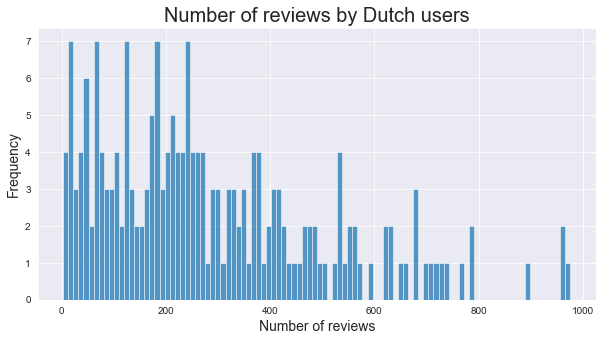

In [4]:
nationality = 'Dutch'

fig = plt.figure( figsize=( 10 , 5 ) )
sns.set_style("darkgrid")

graph = sns.histplot(data=df_users.query('nationality=="{}"'.format(nationality)), x="reviews",bins=100)

graph.set_title(f'Number of reviews by {nationality} users' , size = 20) 
graph.set_xlabel('Number of reviews' , size = 14) 
graph.set_ylabel('Frequency' , size = 14 )

plt.show()

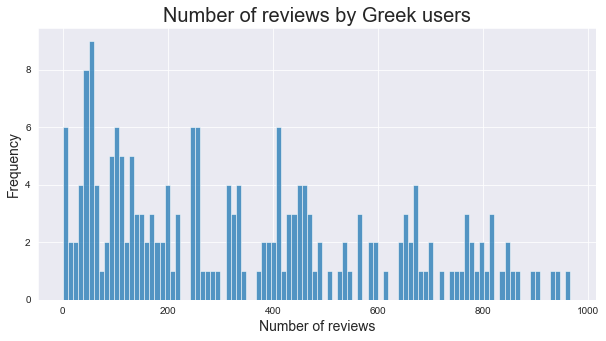

In [5]:
nationality = 'Greek'

fig = plt.figure( figsize=( 10 , 5 ) )
sns.set_style("darkgrid")

graph = sns.histplot(data=df_users.query('nationality=="{}"'.format(nationality)), x="reviews",bins=100)


graph.set_title(f'Number of reviews by {nationality} users' , size = 20) 
graph.set_xlabel('Number of reviews' , size = 14) 
graph.set_ylabel('Frequency' , size = 14 )

plt.show()

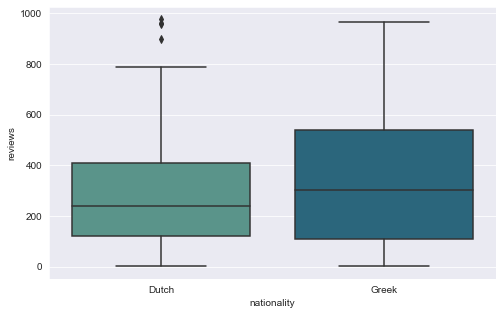

In [6]:
fig = plt.figure( figsize = ( 8, 5))


 
graph = sns.boxplot(data=df_users , x='nationality', y = 'reviews' , palette = 'crest' )


## Number of goodReads friends

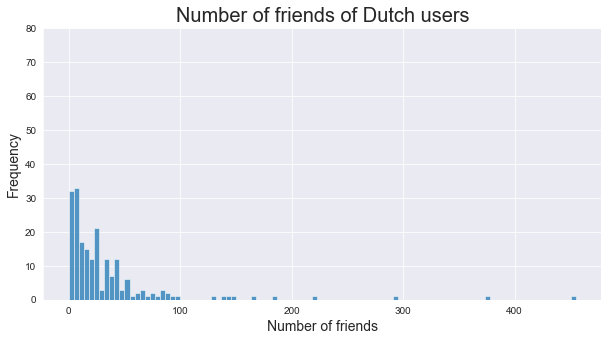

In [7]:
nationality = 'Dutch'

fig = plt.figure( figsize=( 10 , 5 ) )
sns.set_style("darkgrid")

graph = sns.histplot(data=df_users.query('nationality=="{}"'.format(nationality)), x="friends",bins=100)


graph.set_title(f'Number of friends of {nationality} users' , size = 20) 
graph.set_xlabel('Number of friends' , size = 14) 
graph.set_ylabel('Frequency' , size = 14 )
graph.set_ylim(0,80)
plt.show()

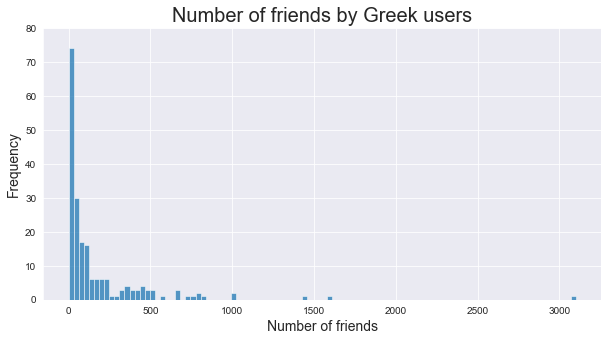

In [8]:
nationality = 'Greek'

fig = plt.figure( figsize=( 10 , 5 ) )
sns.set_style("darkgrid")

graph = sns.histplot(data=df_users.query('nationality=="{}"'.format(nationality)), x="friends",bins=100)


graph.set_title(f'Number of friends by {nationality} users' , size = 20) 
graph.set_xlabel('Number of friends' , size = 14) 
graph.set_ylabel('Frequency' , size = 14 )
graph.set_ylim(0,80)
plt.show()

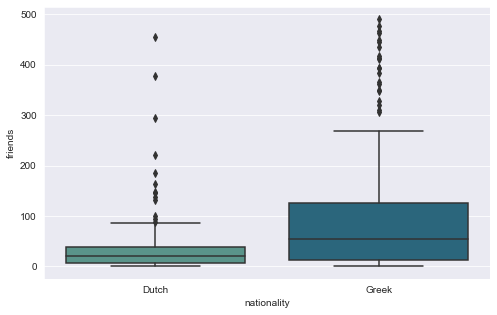

In [9]:
fig = plt.figure( figsize = ( 8, 5))
 
graph = sns.boxplot(data=df_users.query('friends<500') , x='nationality', y = 'friends' , palette = 'crest' )


## Language of reviews

In [10]:
corpus_dir = 'Corpus'

if not os.path.exists(corpus_dir):
    os.makedirs(corpus_dir)

In [11]:
files = []
languages = []
reviews_dir = 'Reviews' 
nr_reviews = 0
log = open('error_log.txt','w',encoding='utf-8')
corpus = open(join(corpus_dir,'greek.txt'),'w',encoding='utf-8')

for i,row in greek_users.iterrows():
    path = join(reviews_dir,f'{row["id"]}.txt')
    if os.path.isfile(path):
        files.append(path)
        

for file in tqdm(files):
    fh = open(file,encoding='utf-8')
    for review in fh:
        try:
            if not(re.search('bookshelves: ',review,re.IGNORECASE)) and re.search(r'\w+',review.strip()):
                full_text = review.strip()
                full_text = re.sub(r'\s+',' ',full_text)
                language = detect(full_text)
                # The package cannot distguish 
                # between Afrikaans and Dutch very well
                if language == 'af':
                    language = 'nl'
                languages.append(language)
                if language == 'en':
                    corpus.write(f'{full_text}\n\n')
                nr_reviews += 1
                
        except:
            log.write('ERROR: ' + full_text)


log.close()
corpus.close()

100%|█████████████████████████████████████████| 172/172 [03:05<00:00,  1.08s/it]


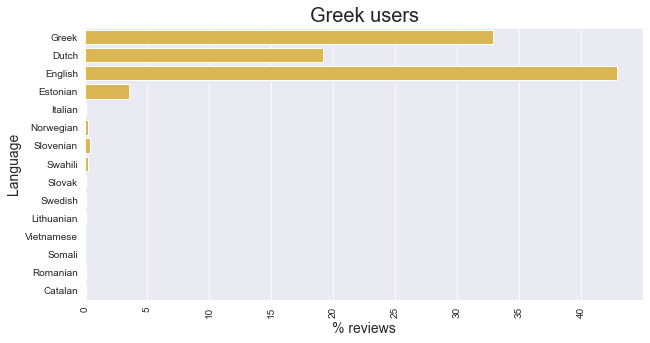

In [12]:

lang_freq = Counter(languages)

y_axis = list(lang_freq.keys())[:15]
y_axis = [Language.make(language=lang).display_name() for lang in y_axis]


x_axis = list(lang_freq.values())[:15]
x_axis = [(lang/nr_reviews)*100 for lang in x_axis]

fig = plt.figure( figsize=( 10 , 5 ) )


graph = sns.barplot( x=x_axis, 
                        y= y_axis, 
                       color = '#f0c03e' )

graph.set_title('Greek users' , size = 20) 
graph.set_xlabel('% reviews' , size = 14) 
graph.set_ylabel('Language' , size = 14 )

plt.xticks(rotation= 90)

plt.show()

In [13]:
files = []
languages = []
reviews_dir = 'Reviews' 
nr_reviews = 0
log = open('error_log.txt','w',encoding='utf-8')
corpus = open(join(corpus_dir,'dutch.txt'),'w',encoding='utf-8')

for i,row in dutch_users.iterrows():
    path = join(reviews_dir,f'{row["id"]}.txt')
    if os.path.isfile(path):
        files.append(path)
        

for file in tqdm(files):
    fh = open(file,encoding='utf-8')
    for review in fh:
        try:
            if not(re.search('bookshelves: ',review,re.IGNORECASE)) and re.search(r'\w+',review.strip()):
                full_text = review.strip()
                full_text = re.sub(r'\s+',' ',full_text)
                language = detect(full_text)
                # The package cannot distinguish 
                # between Afrikaans and Dutch very well
                if language == 'af':
                    language = 'nl'
                languages.append(language)
                if language == 'en':
                    corpus.write(f'{full_text}\n\n')
                nr_reviews += 1
                
        except:
            log.write('ERROR: ' + full_text)


log.close()
corpus.close()

100%|█████████████████████████████████████████| 173/173 [02:31<00:00,  1.14it/s]


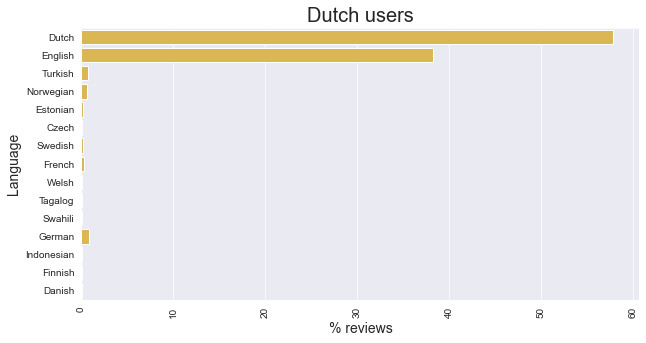

In [14]:

lang_freq = Counter(languages)

y_axis = list(lang_freq.keys())[:15]
y_axis = [Language.make(language=lang).display_name() for lang in y_axis]


x_axis = list(lang_freq.values())[:15]
x_axis = [(lang/nr_reviews)*100 for lang in x_axis]

fig = plt.figure( figsize=( 10 , 5 ) )


graph = sns.barplot( x=x_axis, 
                        y= y_axis, 
                       color = '#f0c03e' )

graph.set_title('Dutch users' , size = 20) 
graph.set_xlabel('% reviews' , size = 14) 
graph.set_ylabel('Language' , size = 14 )

plt.xticks(rotation= 90)

plt.show()

## Average rating

In [15]:
df_rating = pd.read_csv('average_rating.csv')

In [16]:
df_rating.columns

Index(['Unnamed: 0', 'id', 'nationality', 'reviews', 'average_rating'], dtype='object')

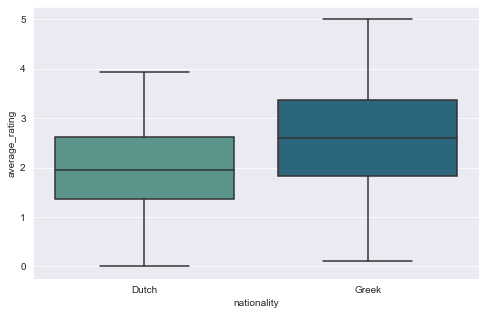

In [17]:
fig = plt.figure( figsize = ( 8, 5))
 
graph = sns.boxplot(data=df_rating , x='nationality', y = 'average_rating' , palette = 'crest' )
